#### 属性信息：

- __InvoiceNo__: 发票编号。标称值，6位整数。如果代码以字母“c”开头，则表示取消
- __StockCode__: 产品代码。标称值，为每个不同的产品唯一分配的5位整数
- __Description__: 产品名
- __Quantity__：产品数量
- __InvoiceDate__：发票日期
- __UnitPrice__：单价。英镑单位的产品价格
- __CustomerID__：客户编码
- __Country__：每个客户所在的国家

In [508]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm

%matplotlib inline

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from sklearn import preprocessing

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
#from IPython.display import display, HTML

from mpl_toolkits.mplot3d import Axes3D

import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [509]:
# IDs are not numerical but strings
df_initial = pd.read_excel("Online Retail.xlsx",dtype={'CustomerID': str,'InvoiceNo': str})

In [510]:
df_eda = df_initial
df_eda.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


## 数据探索(EDA)

In [511]:
# describe() works for numerical data
df_eda.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [512]:
# 检查data type 和 空值
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null object
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [513]:
print('Dataframe dimensions:', df_eda.shape)
df_eda['InvoiceDate'] = pd.to_datetime(df_eda['InvoiceDate'])

# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_eda.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_eda.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_eda.isnull().sum()/df_eda.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)
display(df_eda[:5])

Dataframe dimensions: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0,0,0.268311,0,0,0,24.9267,0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [514]:
#  检查数据里每一列的唯一值
def unique_counts(df1):
    for i in df1.columns:
        count = df1[i].nunique()
        print(i, ":", count)
unique_counts(df_eda)

InvoiceNo : 25900
StockCode : 4070
Description : 4223
Quantity : 722
InvoiceDate : 23260
UnitPrice : 1630
CustomerID : 4372
Country : 38


In [515]:
def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ratio = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ratio', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ratio, uniques, skewness, kurtosis], axis = 1, sort=True)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=True)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

In [516]:
details = rstr(df_eda)
display(details.sort_values(by='missing ratio', ascending=False))

Data shape: (541909, 8)
___________________________
Data types:
 object            5
int64             1
datetime64[ns]    1
float64           1
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing ratio,uniques,skewness,kurtosis
CustomerID,object,406829,4373,135080,24.926694,"[[17850, 13047, 12583, 13748, 15100, 15291, 14...",NaN,NaN
Description,object,540455,4224,1454,0.268311,"[[WHITE HANGING HEART T-LIGHT HOLDER, WHITE ME...",NaN,NaN
Country,object,541909,38,0,0.000000,"[[United Kingdom, France, Australia, Netherlan...",NaN,NaN
InvoiceDate,datetime64[ns],541909,23260,0,0.000000,"[[2010-12-01 08:26:00, 2010-12-01 08:28:00, 20...",NaN,NaN
InvoiceNo,object,541909,25900,0,0.000000,"[[536365, 536366, 536367, 536368, 536369, 5363...",NaN,NaN
Quantity,int64,541909,722,0,0.000000,"[[6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 8...",-0.264076,119769.160031
StockCode,object,541909,4070,0,0.000000,"[[85123A, 71053, 84406B, 84029G, 84029E, 22752...",NaN,NaN
UnitPrice,float64,541909,1630,0,0.000000,"[[2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2....",186.506972,59005.719097


**进一步检查销售数量 和 单价 的负值。describe看到有负值了**

In [517]:
print('数量和单价小于都小于等于0的有多少:',
      df_eda[(df_eda.Quantity<=0) & (df_eda.UnitPrice<=0)].shape[0])

print('这些用户是谁? ',
      df_eda.loc[(df_eda.Quantity<=0) & (df_eda.UnitPrice<=0), 
                 ['CustomerID']].CustomerID.unique())

print('数量小于等于0的:',
      df_eda[(df_eda.Quantity<=0)].shape[0])

print('这些用户是谁? ',
      df_eda.loc[(df_eda.Quantity<=0), ['CustomerID']].CustomerID.unique())

print('\n% 比例是多少: {:3.2%}'.format(df_eda[(df_eda.Quantity<=0)].shape[0]/df_eda.shape[0]))

print('有用户ID的购买数量小于0的，发票抬头:', 
      df_eda.loc[(df_eda.Quantity<=0) & ~(df_eda.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())

数量和单价小于都小于等于0的有多少: 1336
这些用户是谁?  [nan]
数量小于等于0的: 10624
这些用户是谁?  ['14527' '15311' '17548' ... '12985' '15951' '16446']

% 比例是多少: 1.96%
有用户ID的购买数量小于0的，发票抬头: ['C']


In [518]:
display(df_eda[(df_eda.CustomerID=='12472') & (df_eda.StockCode==22244)])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1973,C536548,22244,3 HOOK HANGER MAGIC GARDEN,-4,2010-12-01 14:33:00,1.95,12472,Germany
9438,537201,22244,3 HOOK HANGER MAGIC GARDEN,12,2010-12-05 14:19:00,1.95,12472,Germany
121980,546843,22244,3 HOOK HANGER MAGIC GARDEN,12,2011-03-17 12:40:00,1.95,12472,Germany


In [519]:
print('单价是负的:')
display(df_eda[(df_eda.UnitPrice<0)]) # 详细查看产品信息，发现不是实际产品，而是调整坏账。
print("单价为零，但是用户是有记录的:",df_eda[(df_eda.UnitPrice==0)  & ~(df_eda.CustomerID.isnull())].shape[0])
df_eda[(df_eda.UnitPrice==0)  & ~(df_eda.CustomerID.isnull())]


单价是负的:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


单价为零，但是用户是有记录的: 40


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2011-01-13 15:10:00,0.0,15107,United Kingdom
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.0,17560,United Kingdom
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.0,13239,United Kingdom
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30 12:45:00,0.0,13113,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00,0.0,14410,United Kingdom


In [520]:
# 放弃没有用户ID的
df_eda = df_eda[~(df_eda.CustomerID.isnull())]

# 放弃数量和单价为负的 
df_eda = df_eda[~(df_eda.Quantity<0)]
df_eda = df_eda[df_eda.UnitPrice>0]

details = rstr(df_eda)
display(details.sort_values(by='distincts', ascending=False))

# 考虑到数量为负的其实是取消的订单，应该将相应的下单记录也同时删除。否则计算总购买金额时会有误差。

Data shape: (397884, 8)
___________________________
Data types:
 object            5
int64             1
datetime64[ns]    1
float64           1
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing ratio,uniques,skewness,kurtosis
InvoiceNo,object,397884,18532,0,0.0,"[[536365, 536366, 536367, 536368, 536369, 5363...",-0.178524,-1.200748
InvoiceDate,datetime64[ns],397884,17282,0,0.0,"[[2010-12-01 08:26:00, 2010-12-01 08:28:00, 20...",NaN,NaN
CustomerID,object,397884,4338,0,0.0,"[[17850, 13047, 12583, 13748, 15100, 15291, 14...",0.025729,-1.180822
Description,object,397884,3877,0,0.0,"[[WHITE HANGING HEART T-LIGHT HOLDER, WHITE ME...",NaN,NaN
StockCode,object,397884,3665,0,0.0,"[[85123A, 71053, 84406B, 84029G, 84029E, 22752...",NaN,NaN
UnitPrice,float64,397884,440,0,0.0,"[[2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2....",204.032727,58140.396673
Quantity,int64,397884,301,0,0.0,"[[6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 8...",409.892972,178186.243253
Country,object,397884,37,0,0.0,"[[United Kingdom, France, Australia, Netherlan...",NaN,NaN


## Countries

In [521]:
df_eda.Country.unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Finland',
       'Austria', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Israel', 'Saudi Arabia', 'Czech Republic',
       'Canada', 'Unspecified', 'Brazil', 'USA', 'European Community',
       'Bahrain', 'Malta', 'RSA'], dtype=object)

In [522]:
# 共37个国家
df_eda.Country.value_counts()

United Kingdom          354321
Germany                   9040
France                    8341
EIRE                      7236
Spain                     2484
Netherlands               2359
Belgium                   2031
Switzerland               1841
Portugal                  1462
Australia                 1182
Norway                    1071
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     248
Unspecified                244
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon                     45
Lithuani

In [523]:
df_eda.Country.value_counts(normalize=True)

United Kingdom          0.890513
Germany                 0.022720
France                  0.020963
EIRE                    0.018186
Spain                   0.006243
Netherlands             0.005929
Belgium                 0.005105
Switzerland             0.004627
Portugal                0.003674
Australia               0.002971
Norway                  0.002692
Italy                   0.001905
Channel Islands         0.001880
Finland                 0.001722
Cyprus                  0.001543
Sweden                  0.001133
Austria                 0.001000
Denmark                 0.000955
Poland                  0.000829
Japan                   0.000807
Israel                  0.000623
Unspecified             0.000613
Singapore               0.000558
Iceland                 0.000457
USA                     0.000450
Canada                  0.000380
Greece                  0.000364
Malta                   0.000281
United Arab Emirates    0.000171
European Community      0.000151
RSA       

In [524]:
customer_country2 = df_eda.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID',ascending=False)

In [525]:
customer_country2

,Country,CustomerID
35,United Kingdom,354321
14,Germany,9040
13,France,8341
10,EIRE,7236
30,Spain,2484
23,Netherlands,2359
3,Belgium,2031
32,Switzerland,1841
26,Portugal,1462
0,Australia,1182


In [526]:
customer_country2['Percentage'] = round(customer_country2['CustomerID']/sum(customer_country2['CustomerID'])*100,2)

In [527]:
# 大多数数据都来自于英国本土
customer_country2.head(10)

,Country,CustomerID,Percentage
35,United Kingdom,354321,89.05
14,Germany,9040,2.27
13,France,8341,2.10
10,EIRE,7236,1.82
30,Spain,2484,0.62
23,Netherlands,2359,0.59
3,Belgium,2031,0.51
32,Switzerland,1841,0.46
26,Portugal,1462,0.37
0,Australia,1182,0.30


In [528]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      397884 non-null object
StockCode      397884 non-null object
Description    397884 non-null object
Quantity       397884 non-null int64
InvoiceDate    397884 non-null datetime64[ns]
UnitPrice      397884 non-null float64
CustomerID     397884 non-null object
Country        397884 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.3+ MB


In [529]:
df_eda['amount'] = df_eda.Quantity*df_eda.UnitPrice

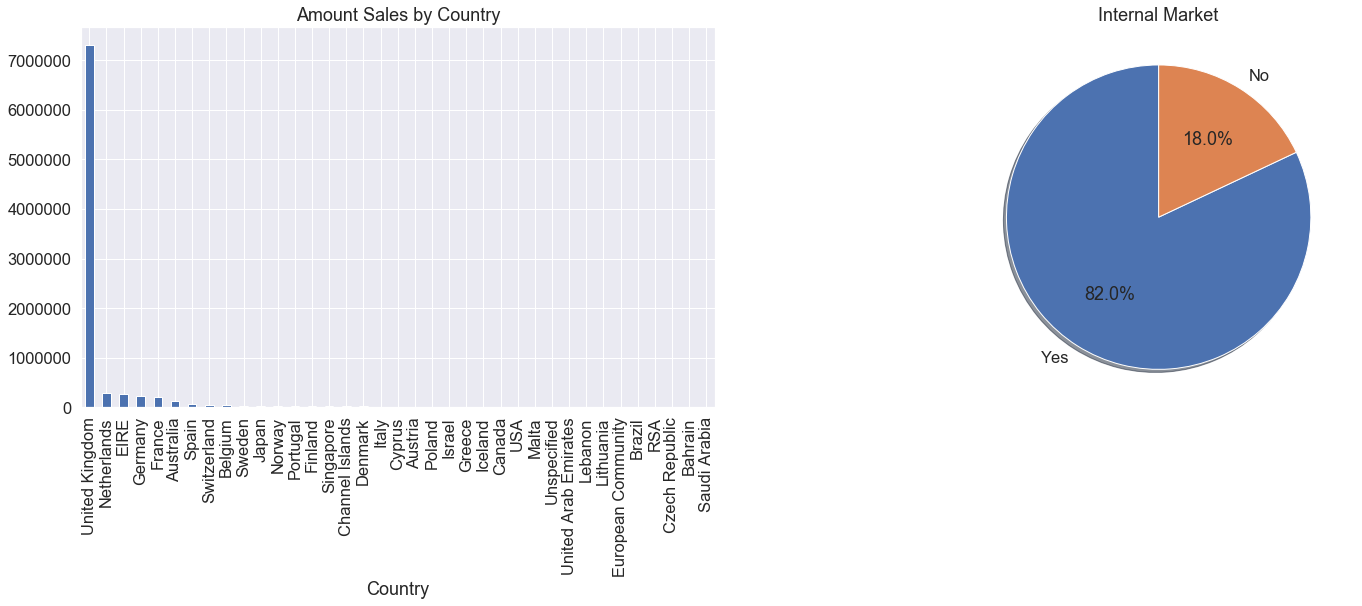

In [530]:
fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
g = df_eda.groupby(["Country"]).amount.sum().sort_values(ascending = False).plot(kind='bar', title='Amount Sales by Country')
df_eda['Internal'] = df_eda.Country.apply(lambda x: 'Yes' if x=='United Kingdom' else 'No' )
f2 = fig.add_subplot(122)
market = df_eda.groupby(["Internal"]).amount.sum().sort_values(ascending = False)
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Internal Market')
plt.show()

## 成交额

In [531]:
# 再来检查一下最早和最晚的订单日期
print(df_eda['InvoiceDate'].min())
print(df_eda['InvoiceDate'].max())

2010-12-01 08:26:00
2011-12-09 12:50:00


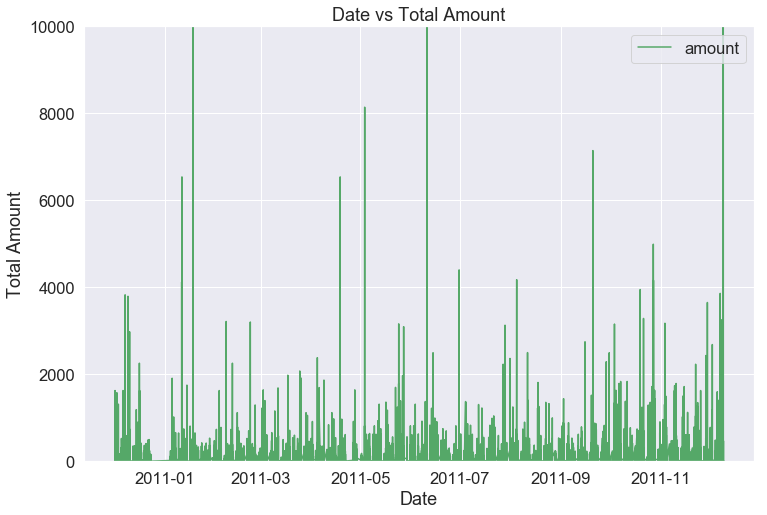

In [532]:
plt.figure(figsize=(12,8))
plt.plot(df_eda['InvoiceDate'],df_eda['amount'],color='g')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.title('Date vs Total Amount')
plt.ylim(0,10000)
plt.legend()
plt.show()

In [533]:
df_eda['Weekday'] = df_eda['InvoiceDate'].dt.weekday
df_eda['weekday_name'] = df_eda['InvoiceDate'].dt.weekday_name

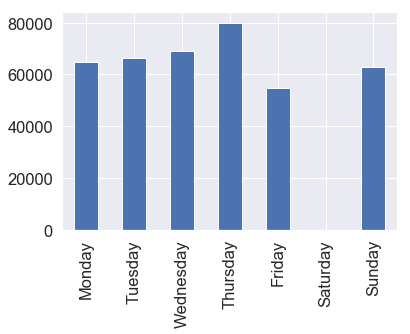

In [534]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']

df_eda['DAY_OF_WEEK'] = pd.Categorical(df_eda['weekday_name'], categories=days, ordered=True)
crashes_by_day = df_eda['DAY_OF_WEEK'].value_counts()
crashes_by_day = crashes_by_day.sort_index()
crashes_by_day.plot(kind='bar')

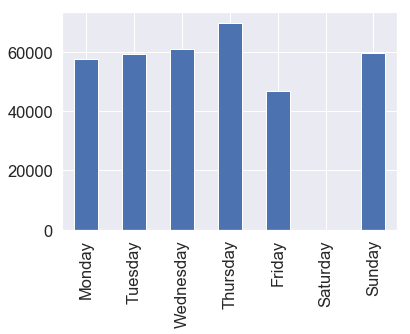

In [535]:
# 因为英国本土的客户占了90%，所以我们只选择英国本土的数据进行可视化与分类
df_uk = df_eda.loc[df_eda['Country'] == 'United Kingdom']
crashes_by_day = df_uk['DAY_OF_WEEK'].value_counts()
crashes_by_day = crashes_by_day.sort_index()
crashes_by_day.plot(kind='bar')

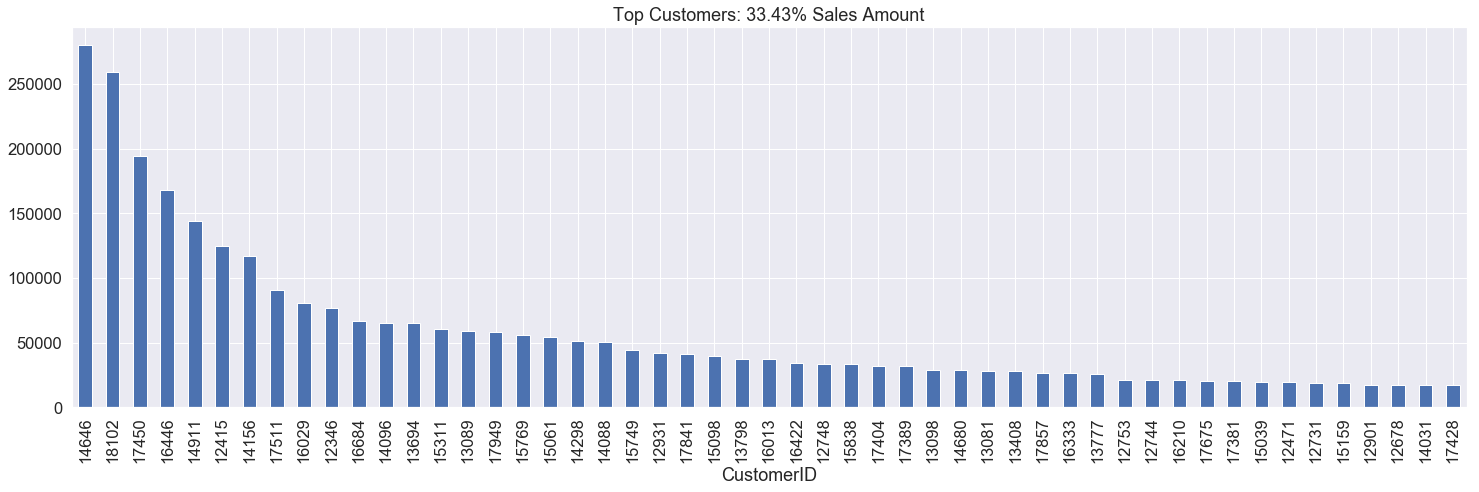

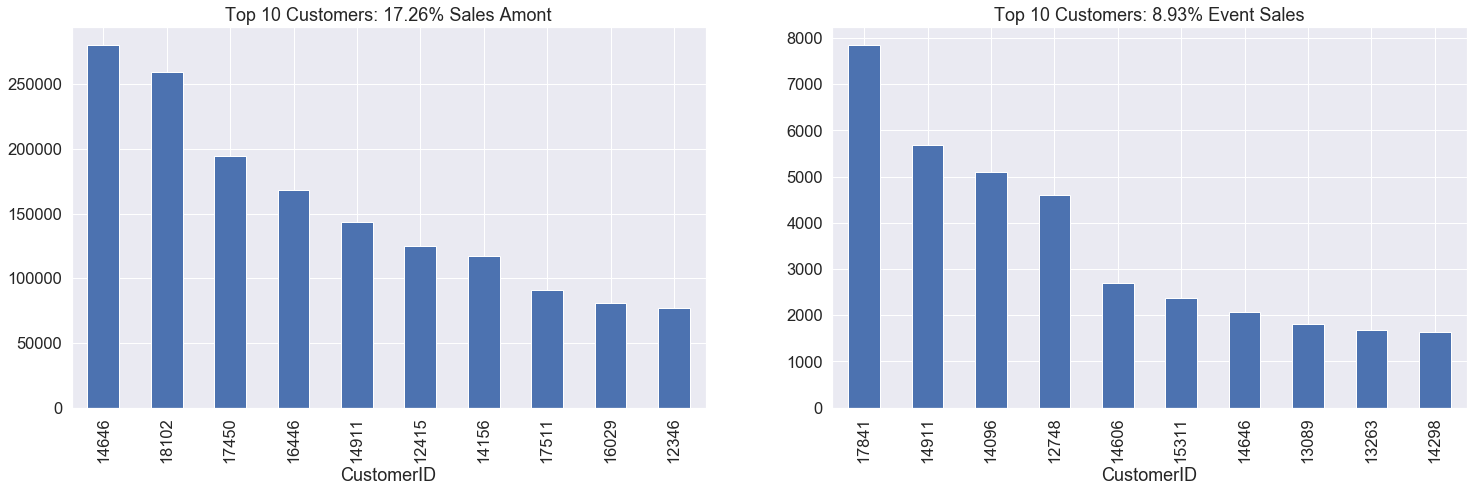

In [536]:
# top 50, top 10 客户的销售贡献

fig = plt.figure(figsize=(25, 7))
PercentSales =  np.round((df_eda.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False)[:51].sum()/df_eda.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)

g = df_eda.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False)[:51].\
    plot(kind='bar', title='Top Customers: {:3.2f}% Sales Amount'.format(PercentSales))

fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
PercentSales =  np.round((df_eda.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False)[:10].sum()/df_eda.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)
g = df_eda.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False)[:10]\
    .plot(kind='bar', title='Top 10 Customers: {:3.2f}% Sales Amont'.format(PercentSales))
f1 = fig.add_subplot(122)
PercentSales =  np.round((df_eda.groupby(["CustomerID"]).amount.count().\
                          sort_values(ascending = False)[:10].sum()/df_eda.groupby(["CustomerID"]).\
                          amount.count().sort_values(ascending = False).sum()) * 100, 2)
g = df_eda.groupby(["CustomerID"]).amount.count().sort_values(ascending = False)[:10].\
    plot(kind='bar', title='Top 10 Customers: {:3.2f}% Event Sales'.format(PercentSales))

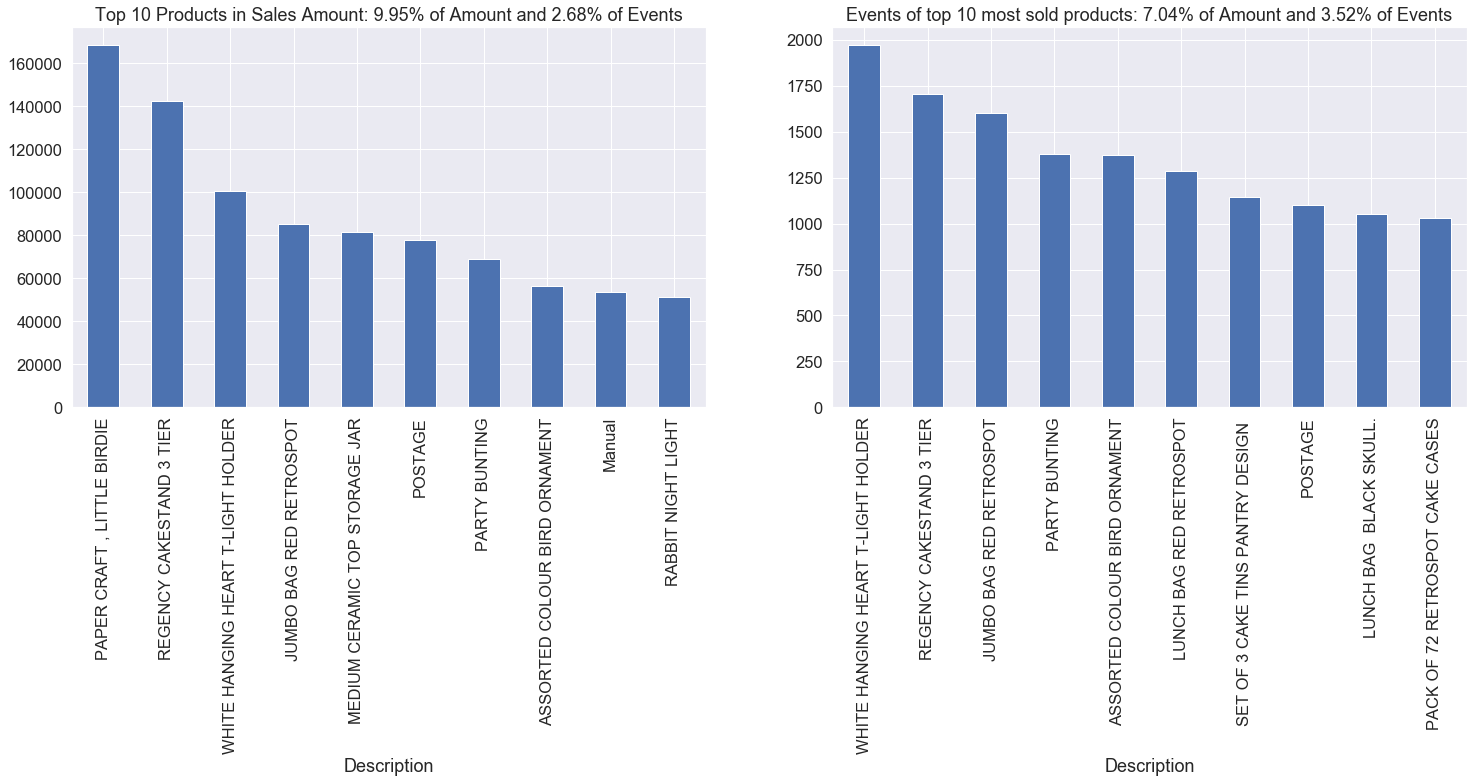

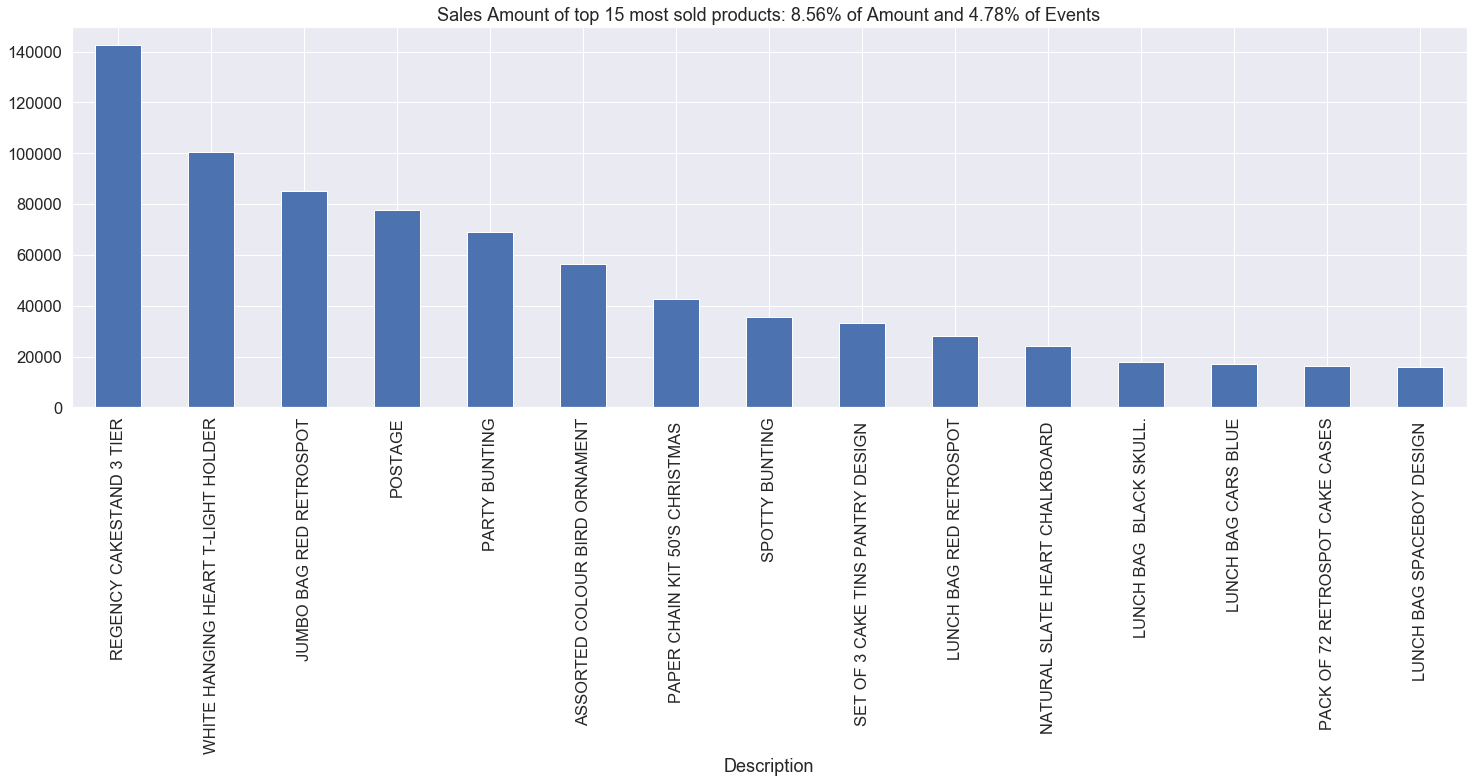

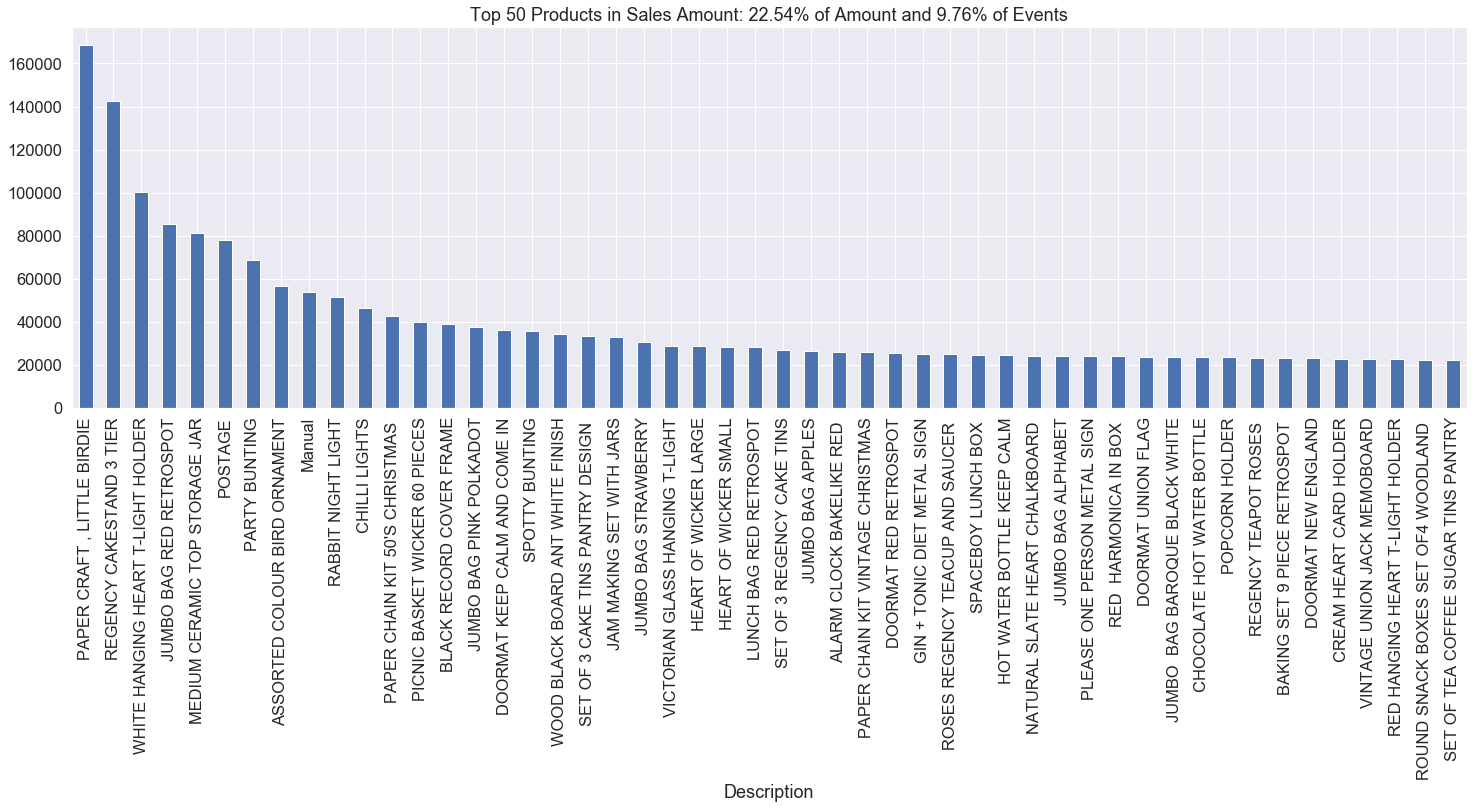

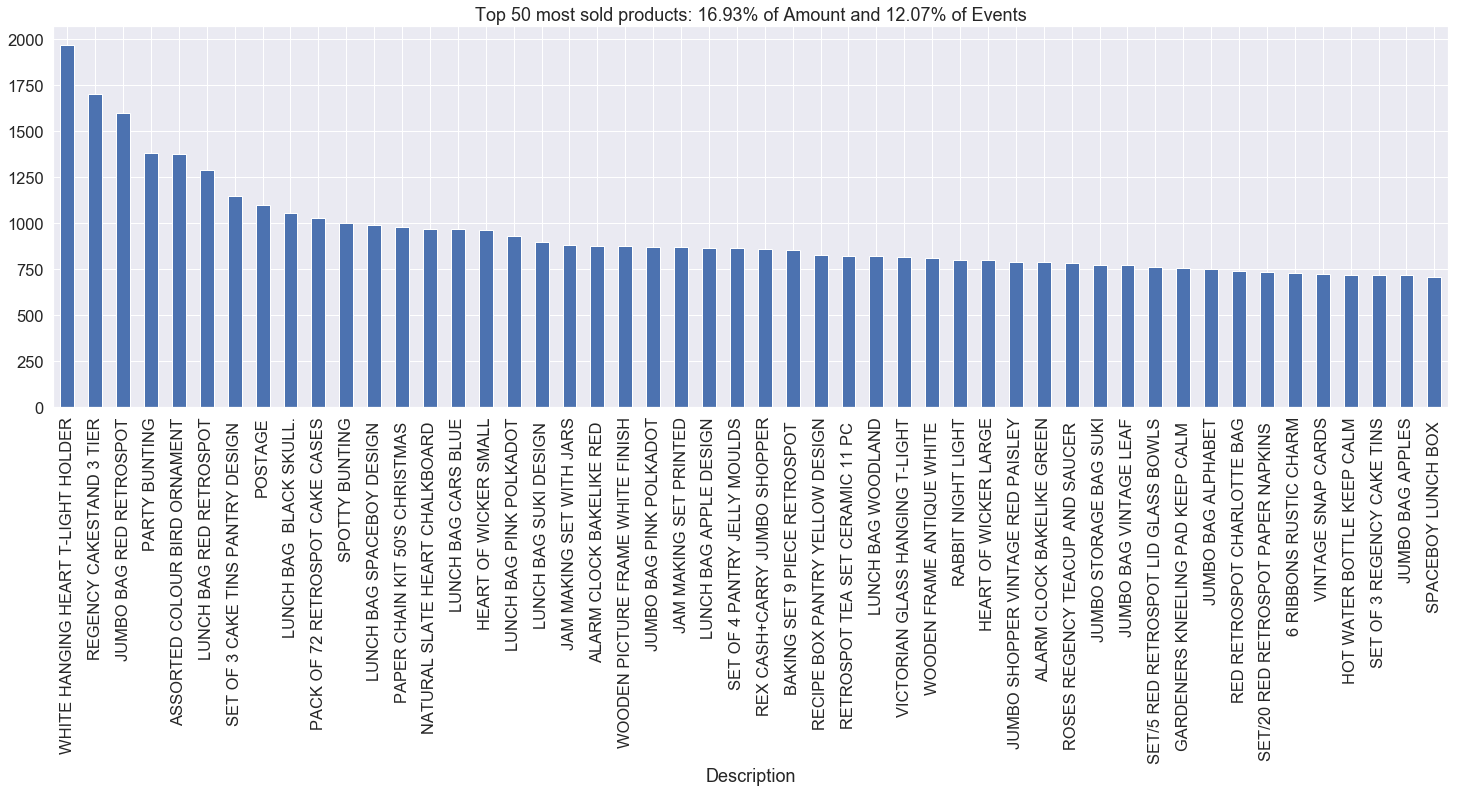

In [537]:
# top products

AmoutSum = df_eda.groupby(["Description"]).amount.sum().sort_values(ascending = False)
inv = df_eda[["Description", "InvoiceNo"]].groupby(["Description"]).InvoiceNo.unique().\
      agg(np.size).sort_values(ascending = False)

fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
Top10 = list(AmoutSum[:10].index)
PercentSales =  np.round((AmoutSum[Top10].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top10].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top10].\
    plot(kind='bar', title='Top 10 Products in Sales Amount: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))

f1 = fig.add_subplot(122)
Top10Ev = list(inv[:10].index)
PercentSales =  np.round((AmoutSum[Top10Ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top10Ev].sum()/inv.sum()) * 100, 2)
g = inv[Top10Ev].\
    plot(kind='bar', title='Events of top 10 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))


fig = plt.figure(figsize=(25, 7))
Top15ev = list(inv[:15].index)
PercentSales =  np.round((AmoutSum[Top15ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top15ev].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top15ev].sort_values(ascending = False).\
    plot(kind='bar', 
         title='Sales Amount of top 15 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
         format(PercentSales, PercentEvents))

fig = plt.figure(figsize=(25, 7))
Top50 = list(AmoutSum[:50].index)
PercentSales =  np.round((AmoutSum[Top50].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top50].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top50].\
    plot(kind='bar', 
         title='Top 50 Products in Sales Amount: {:3.2f}% of Amount and {:3.2f}% of Events'.\
         format(PercentSales, PercentEvents))

fig = plt.figure(figsize=(25, 7))
Top50Ev = list(inv[:50].index)
PercentSales =  np.round((AmoutSum[Top50Ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top50Ev].sum()/inv.sum()) * 100, 2)
g = inv[Top50Ev].\
    plot(kind='bar', title='Top 50 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))


Dupliated Records

In [538]:
df_eda.shape

(397884, 13)

In [539]:
df_eda.duplicated().sum()

5192

In [540]:
df1 = df_eda

In [541]:
df1.drop_duplicates(inplace=True)

In [542]:
df1.shape

(392692, 13)

# <font color ='blue'>__第二部分：RFM Customer Segmentation 顾客分类__</font>

### 5. 我们将会用零售数据进行RFM模型的分析从而提高顾客的终身价值

In [543]:
df1.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,Internal,Weekday,weekday_name,DAY_OF_WEEK
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.3,Yes,2,Wednesday,Wednesday


In [544]:
df1.shape

(392692, 13)

#### Recency

In [545]:
refrence_date = df1.InvoiceDate.max() + datetime.timedelta(days = 1)

In [546]:
print('Reference Date:', refrence_date)
df1['days_since_last_purchase'] = (refrence_date - df1.InvoiceDate).astype('timedelta64[D]')
customer_history_df =  df1[['CustomerID', 'days_since_last_purchase']].groupby("CustomerID").min().reset_index()
customer_history_df.rename(columns={'days_since_last_purchase':'recency'}, inplace=True)
customer_history_df.describe().transpose()

Reference Date: 2011-12-10 12:50:00


,count,mean,std,min,25%,50%,75%,max
recency,4338.0,92.536422,100.014169,1.0,18.0,51.0,142.0,374.0


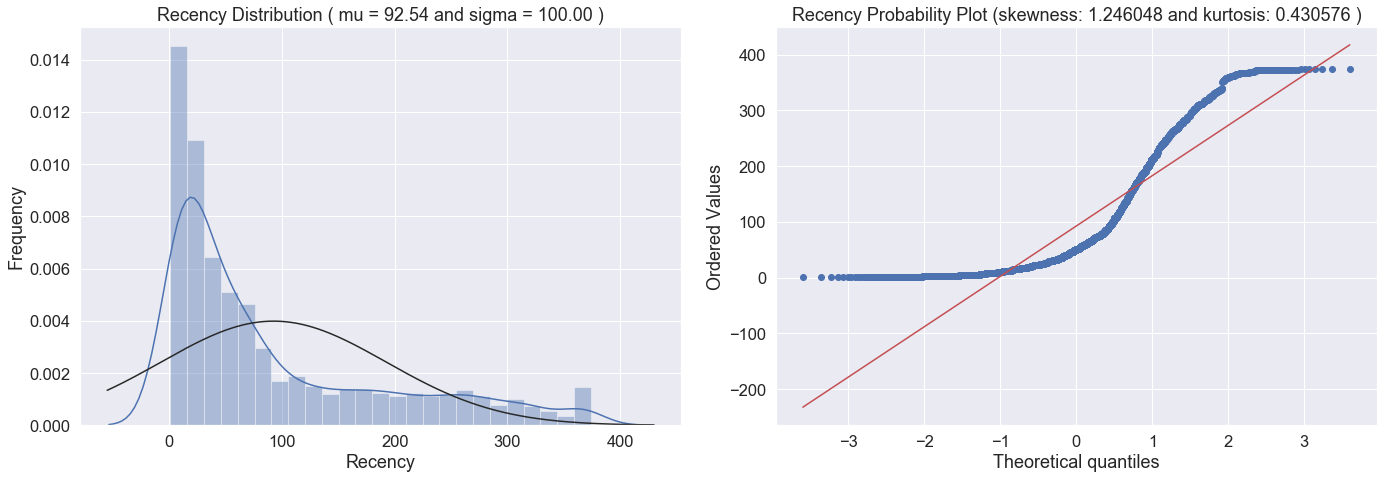

In [547]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

QQ_plot(customer_history_df.recency, 'Recency')

#### Frequency

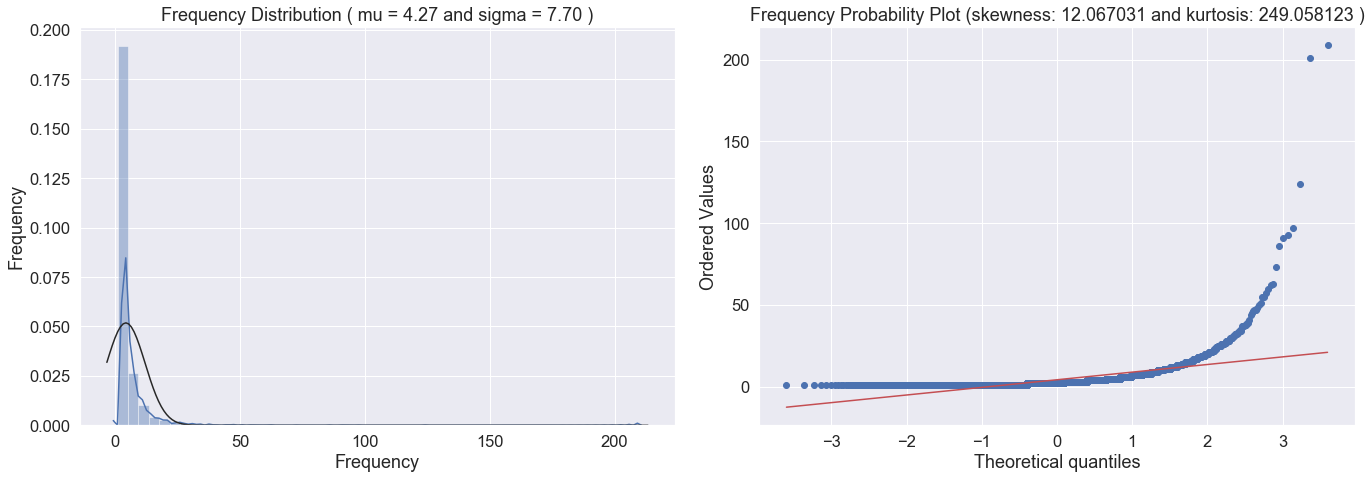

In [548]:
customer_freq = (df1[['CustomerID', 'InvoiceNo']].groupby(["CustomerID", 'InvoiceNo']).count().reset_index()).\
                groupby(["CustomerID"]).count().reset_index()
customer_freq.rename(columns={'InvoiceNo':'frequency'},inplace=True)
customer_history_df = customer_history_df.merge(customer_freq)
QQ_plot(customer_history_df.frequency, 'Frequency')

In [549]:
customer_history_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
recency,4338.0,92.536422,100.014169,1.0,18.0,51.0,142.0,374.0
frequency,4338.0,4.272015,7.697998,1.0,1.0,2.0,5.0,209.0


#### Monetary Value

In [550]:
customer_history_df.head()

,CustomerID,recency,frequency
0,12346,326.0,1
1,12347,2.0,7
2,12348,75.0,4
3,12349,19.0,1
4,12350,310.0,1


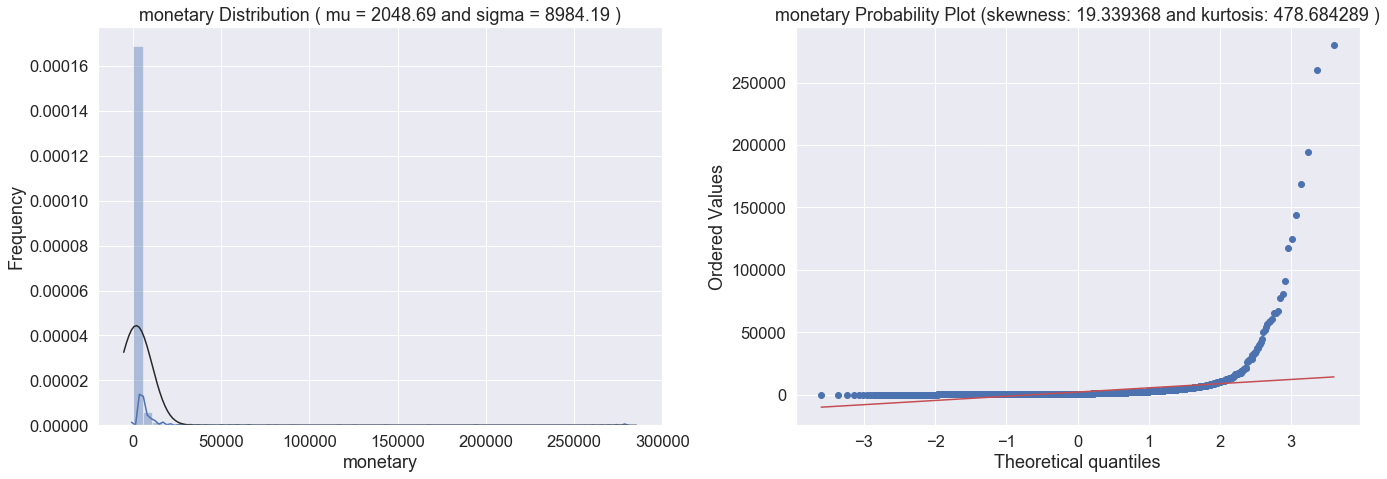

In [551]:
customer_monetary_val = df1[['CustomerID', 'amount']].groupby("CustomerID").sum().reset_index()
customer_history_df = customer_history_df.merge(customer_monetary_val)
customer_history_df.rename(columns={'amount':'monetary'}, inplace=True)
QQ_plot(customer_history_df.monetary, 'monetary')

In [552]:
customer_history_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
recency,4338.0,92.536422,100.014169,1.00,18.0000,51.00,142.0000,374.00
frequency,4338.0,4.272015,7.697998,1.00,1.0000,2.00,5.0000,209.00
monetary,4338.0,2048.688081,8985.230220,3.75,306.4825,668.57,1660.5975,280206.02


In [553]:
rfmTable = customer_history_df

In [554]:
rfmTable.head(5)

,CustomerID,recency,frequency,monetary
0,12346,326.0,1,77183.60
1,12347,2.0,7,4310.00
2,12348,75.0,4,1797.24
3,12349,19.0,1,1757.55
4,12350,310.0,1,334.40


##### _注释_:

1. CustomerID 12346的粘性（最近交易距离）为326天，忠诚度（累计单数）为1单，收入（累计交易金额）为77183.6美元
2. CustomerID 12347的粘性（最近交易距离）为2天，忠诚度（累计单数）为182单，收入（累计交易金额）为4310.0美元

In [555]:
# 让我们来看看12346客户的详细信息
first_customer = df1[df1['CustomerID']=='12346']
first_customer

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,Internal,Weekday,weekday_name,DAY_OF_WEEK,days_since_last_purchase
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.6,Yes,1,Tuesday,Tuesday,326.0


##### 我们可以看出，第一位客户只够买了一次，但是购买这件产品的数量很高，单价很低，有可能是清仓大甩买

### RFM 打分

In [556]:
# 我们现在可以手动利用四分位数将指标划分，便于理解和解释
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [557]:
# 我们创建一个新，叫'segmented_rfm'
segmented_rfm = rfmTable

In [558]:
quantiles

{'recency': {0.25: 18.0, 0.5: 51.0, 0.75: 142.0},
 'frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'monetary': {0.25: 306.48249999999996,
  0.5: 668.5699999999999,
  0.75: 1660.5975000000012}}

In [559]:
# 我们最想要的客户是：粘性高，忠诚度和收入高的用户
# 一般分成 3~5 段，这里我们分为4段
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1
    

In [560]:
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary'].apply(FMScore, args=('monetary',quantiles,))

In [561]:
segmented_rfm.head(5)

,CustomerID,recency,frequency,monetary,r_quartile,f_quartile,m_quartile
0,12346,326.0,1,77183.60,4,4,1
1,12347,2.0,7,4310.00,1,1,1
2,12348,75.0,4,1797.24,3,2,1
3,12349,19.0,1,1757.55,2,4,1
4,12350,310.0,1,334.40,4,4,3


In [562]:
# R F M
#RFM score = r*100+f*10+m, 111 为rfm score的最高分
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) \
                              + segmented_rfm.f_quartile.map(str) \
                              + segmented_rfm.m_quartile.map(str)

segmented_rfm.head(5)

,CustomerID,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFMScore
0,12346,326.0,1,77183.60,4,4,1,441
1,12347,2.0,7,4310.00,1,1,1,111
2,12348,75.0,4,1797.24,3,2,1,321
3,12349,19.0,1,1757.55,2,4,1,241
4,12350,310.0,1,334.40,4,4,3,443


In [563]:
# 很明显第一个顾客不是我们最想要的顾客，他是通过特定时间以便宜的单价买入很高的量
# 我们现在来选择出我们最好的10个用户
segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('monetary',ascending=False).head(10)

,CustomerID,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFMScore
1689,14646,2.0,73,280206.02,1,1,1,111
4201,18102,1.0,60,259657.30,1,1,1,111
3728,17450,8.0,46,194390.79,1,1,1,111
1879,14911,1.0,201,143711.17,1,1,1,111
1333,14156,10.0,55,117210.08,1,1,1,111
3771,17511,3.0,31,91062.38,1,1,1,111
3176,16684,4.0,28,66653.56,1,1,1,111
1289,14096,4.0,17,65164.79,1,1,1,111
996,13694,4.0,50,65039.62,1,1,1,111
2176,15311,1.0,91,60632.75,1,1,1,111


In [564]:
print(segmented_rfm['RFMScore'].value_counts().count())
print(segmented_rfm['RFMScore'].max())
print(segmented_rfm['RFMScore'].min())

61
444
111


|R分段|得分|F分段|得分|M分段|得分|
|---|---|---|---|---|---|
|活跃用户|1|忠实客户|1|高贡献|1|
|沉默用户|2|成熟客户|2|中高贡献|2|
|睡眠用户|3|老客户|3|中贡献|3|
|流失用户|4|新客户|4|低贡献|4|


基于此做打分分组，制定不同的策略，比如
- 0 - 122, 最有价值客户，价格不会是很敏感，所以主要推广忠实项目和新品
- 122 - 223，快要逐渐失去的客户，email或者渠道推广一下
- 223 - 333, 最近没怎么购买的有价值客户，需要进一步激活，给一下打折，做一波email推广

或者可以分得更细致，主要看运营能力

In [565]:
segmented_rfm['RFMScore'] = segmented_rfm['RFMScore'].astype(int)

def rfm_level(RFMScore):
    if (RFMScore >= 0 and RFMScore < 122):
        return '1'
    elif (RFMScore >= 122 and RFMScore < 223):
        return '2'
    elif (RFMScore >= 223 and RFMScore < 333):
        return '3'
    return '4'

segmented_rfm['RFMScore_level'] = segmented_rfm['RFMScore'].apply(rfm_level).astype(str)

In [566]:
segmented_rfm.head()

,CustomerID,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFMScore,RFMScore_level
0,12346,326.0,1,77183.60,4,4,1,441,4
1,12347,2.0,7,4310.00,1,1,1,111,1
2,12348,75.0,4,1797.24,3,2,1,321,3
3,12349,19.0,1,1757.55,2,4,1,241,3
4,12350,310.0,1,334.40,4,4,3,443,4


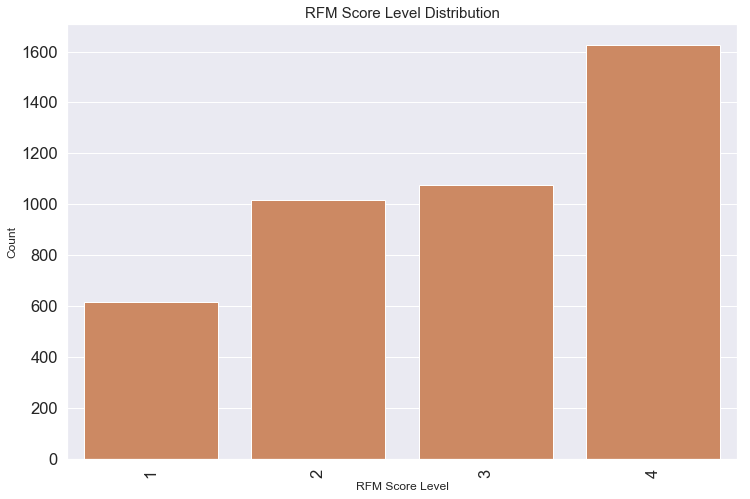

In [567]:
# 让我们来看一看不同rfm 分数的分布
import seaborn as sns
color = sns.color_palette()

plt.figure(figsize=(12,8))
sns.countplot(x='RFMScore_level',data=segmented_rfm, color = color[1])
plt.ylabel('Count',fontsize=12)
plt.xlabel('RFM Score Level', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('RFM Score Level Distribution',fontsize=15)
plt.show()

# <font color ='blue'>__第三部分：基于统计模型来分类RFM指标__</font>

### K-means Clustering

In [568]:
customer_history_df.head(1)

,CustomerID,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFMScore,RFMScore_level
0,12346,326.0,1,77183.6,4,4,1,441,4


In [569]:
customer_history_df.describe()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFMScore
count,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2048.688081,2.486169,2.679806,2.500000,277.914938
std,100.014169,7.697998,8985.230220,1.126296,1.143825,1.118369,119.655140
min,1.000000,1.000000,3.750000,1.000000,1.000000,1.000000,111.000000
25%,18.000000,1.000000,306.482500,1.000000,2.000000,1.250000,144.000000
50%,51.000000,2.000000,668.570000,2.000000,3.000000,2.500000,244.000000
75%,142.000000,5.000000,1660.597500,3.000000,4.000000,3.750000,344.000000
max,374.000000,209.000000,280206.020000,4.000000,4.000000,4.000000,444.000000


In [ ]:
preprocessing.StandardScaler?

In [570]:
# data preprocessing

segmented_rfm['recency_log'] = customer_history_df['recency'].apply(math.log)
customer_history_df['frequency_log'] = customer_history_df['frequency'].apply(math.log)
customer_history_df['monetary_log'] = customer_history_df['monetary'].apply(math.log)
feature_vector = ['monetary_log', 'recency_log','frequency_log']
X_subset = customer_history_df[feature_vector] #.as_matrix()
scaler = preprocessing.StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)
pd.DataFrame(X_scaled, columns=X_subset.columns).describe().T

,count,mean,std,min,25%,50%,75%,max
monetary_log,4338.0,3.931080e-17,1.000115,-4.172381,-0.682096,-0.063857,0.657274,4.722173
recency_log,4338.0,-1.048288e-16,1.000115,-2.630445,-0.612424,0.114707,0.829652,1.505796
frequency_log,4338.0,-9.991495e-17,1.000115,-1.048610,-1.048610,-0.279044,0.738267,4.882714


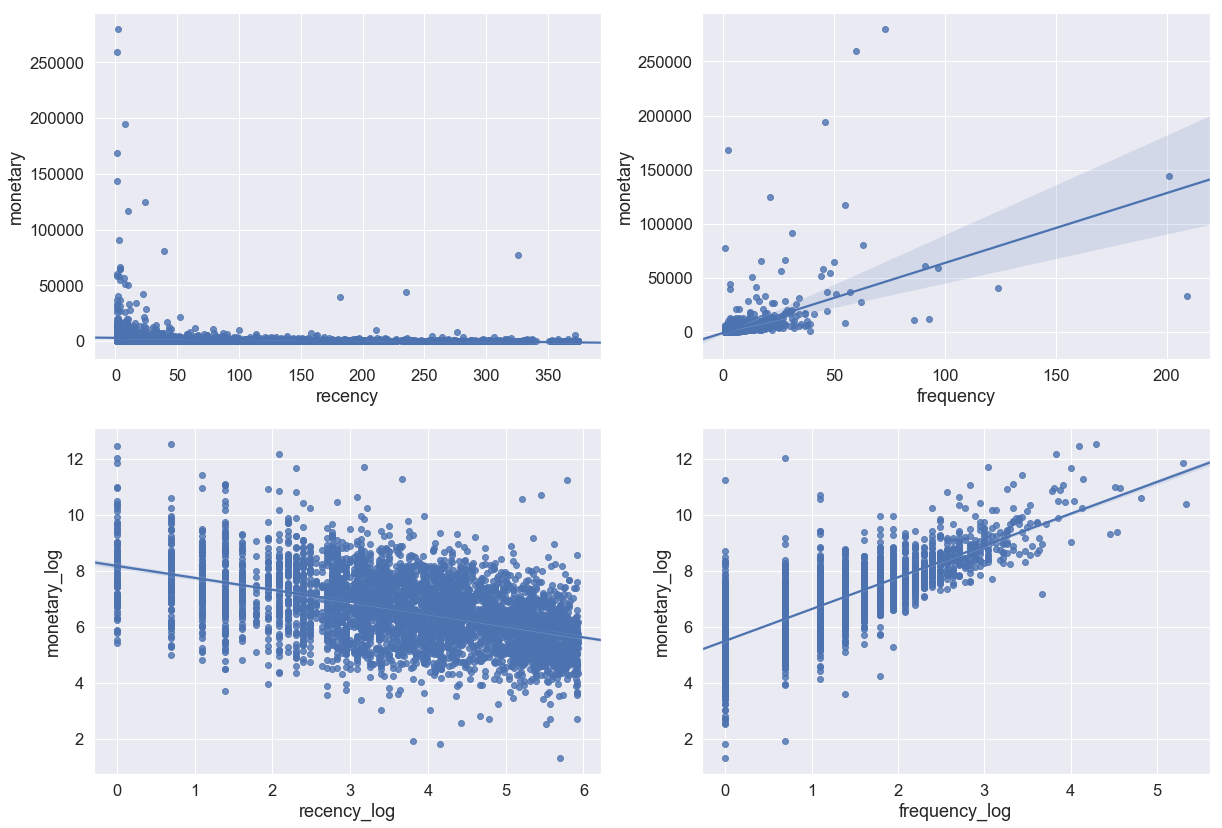

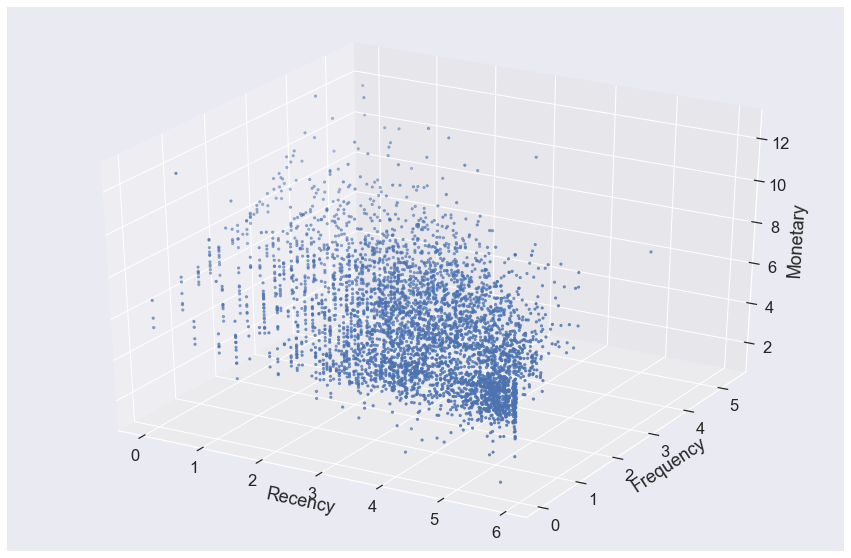

In [571]:
fig = plt.figure(figsize=(20,14))
f1 = fig.add_subplot(221); sns.regplot(x='recency', y='monetary', data=customer_history_df)
f1 = fig.add_subplot(222); sns.regplot(x='frequency', y='monetary', data=customer_history_df)
f1 = fig.add_subplot(223); sns.regplot(x='recency_log', y='monetary_log', data=customer_history_df)
f1 = fig.add_subplot(224); sns.regplot(x='frequency_log', y='monetary_log', data=customer_history_df)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

xs =customer_history_df.recency_log
ys = customer_history_df.frequency_log
zs = customer_history_df.monetary_log
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()

##### K-means++
- Place the initial centroids far away from each other via the k-means++ algorithm, which leads to better and more consistent results than the classic k-means.
- To use k-means++ with scikit-learn's KMeans object, we just need to set the init parameter to k-means++ (the default setting) instead of random.

#### The Elbow Method
  
Using the elbow method to find the optimal number of clusters. The idea behind the elbow method is to identify the value of k where the distortion begins to increase most rapidly. If k increases, the distortion will decrease, because the samples will be closer to the centroids they are assigned to. 

This method looks at the percentage of variance explained as a function of the number of clusters. More precisely, if one plots the percentage of variance explained by the clusters against the number of clusters, the first clusters will add much information (explain a lot of variance), but at some point the marginal gain will drop, giving an angle in the graph. The number of clusters is chosen at this point, hence the "elbow criterion". This "elbow" cannot always be unambiguously identified.Percentage of variance explained is the ratio of the between-group variance to the total variance, also known as an F-test. A slight variation of this method plots the curvature of the within group variance.

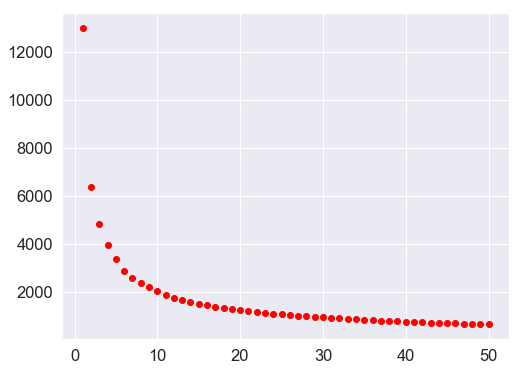

In [572]:
cl = 50
corte = 0.1

anterior = 100000000000000
cost = [] 
K_best = cl

for k in range (1, cl+1):
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    model = KMeans(
        n_clusters=k, 
        init='k-means++', #'random',
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=101)

    model = model.fit(X_scaled)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = model.labels_
 
    # Sum of distances of samples to their closest cluster center
    interia = model.inertia_
    if (K_best == cl) and (((anterior - interia)/anterior) < corte): K_best = k - 1
    cost.append(interia)
    anterior = interia

plt.figure(figsize=(8, 6))
plt.scatter(range (1, cl+1), cost, c='red')
plt.show()


In [573]:
K_best  # variance <10% when k increases from 7 to 8

7

The best K sugest:  7


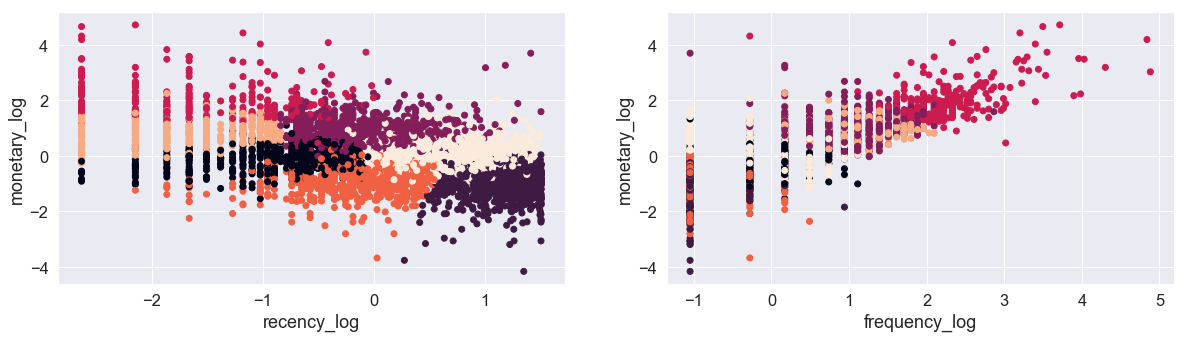

In [574]:
# Create a kmeans model with the best K.
print('The best K sugest: ',K_best)
model = KMeans(n_clusters=K_best, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)

# Note I'm scaling the data to normalize it! Important for good results.
model = model.fit(X_scaled)

# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
labels = model.labels_

# And we'll visualize it:
#plt.scatter(X_scaled[:,0], X_scaled[:,1], c=model.labels_.astype(float))
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
plt.scatter(x = X_scaled[:,1], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[1])
ax.set_ylabel(feature_vector[0])
ax = fig.add_subplot(122)
plt.scatter(x = X_scaled[:,2], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[2])
ax.set_ylabel(feature_vector[0])

plt.show()

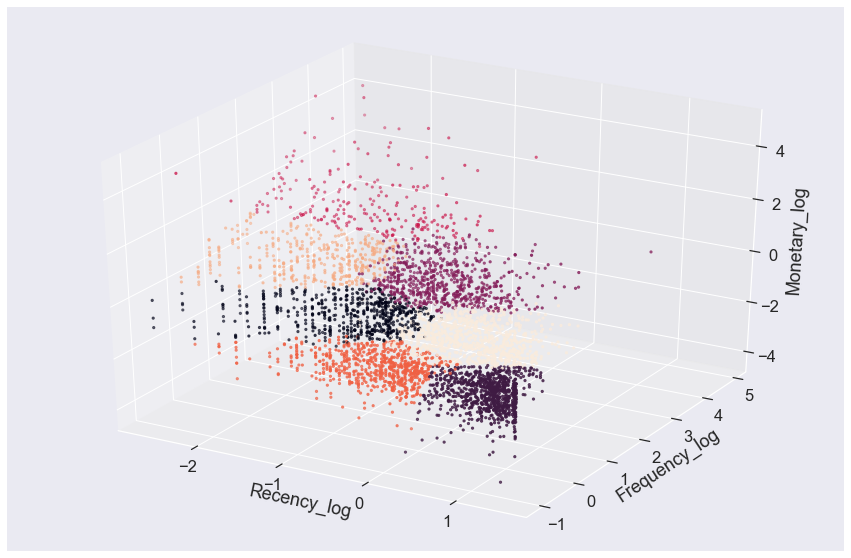

In [575]:
# 3D plot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

xs = X_scaled[:,1]
ys = X_scaled[:,2]
zs = X_scaled[:,0]
ax.scatter(xs, ys, zs, s=5,c=model.labels_.astype(float) )

ax.set_xlabel('Recency_log')
ax.set_ylabel('Frequency_log')
ax.set_zlabel('Monetary_log')

plt.show()

#### Silhouette analysis on K-Means clustering


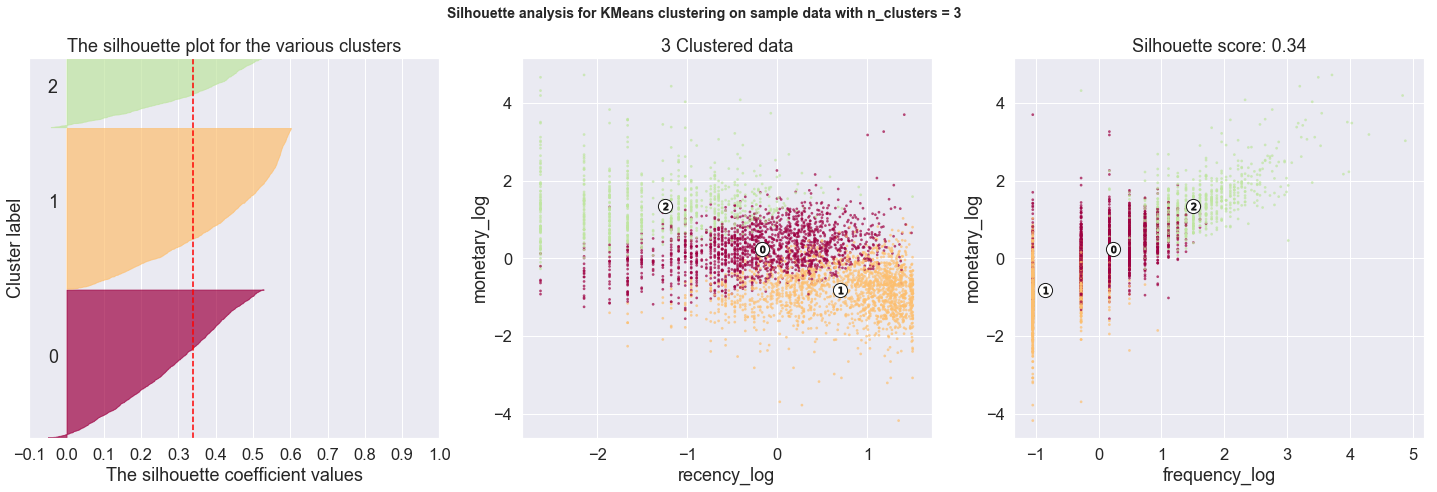

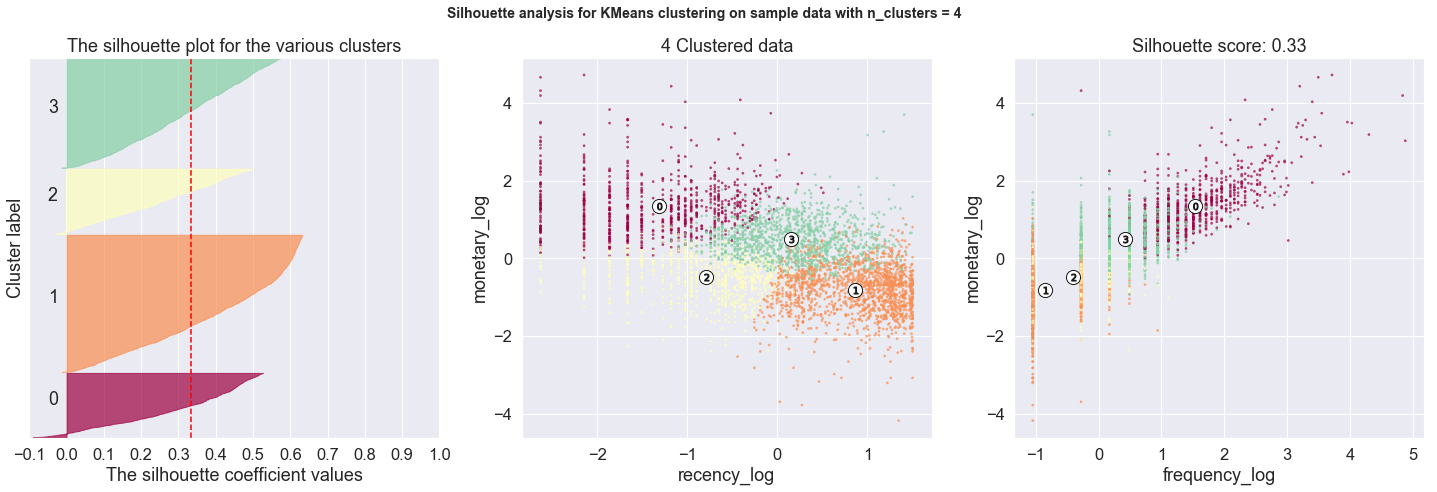

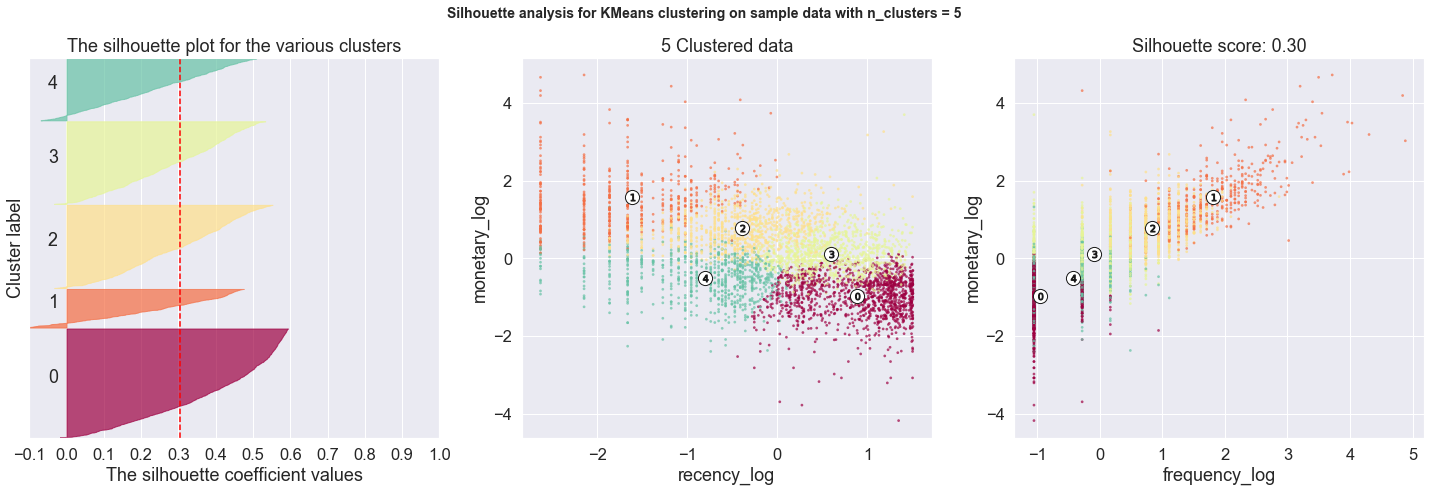

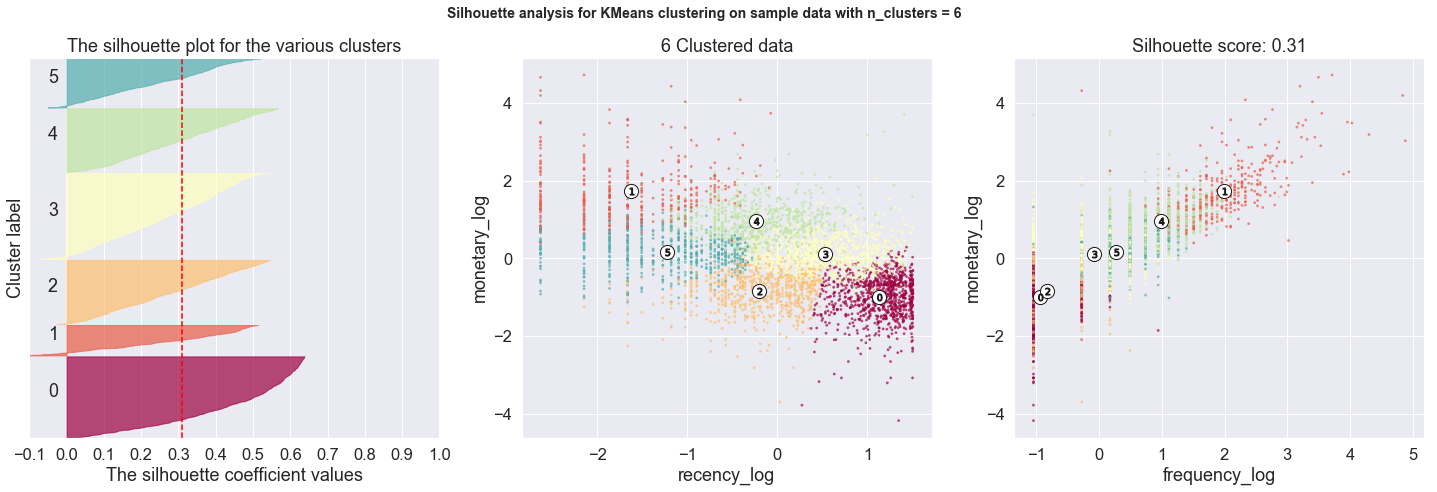

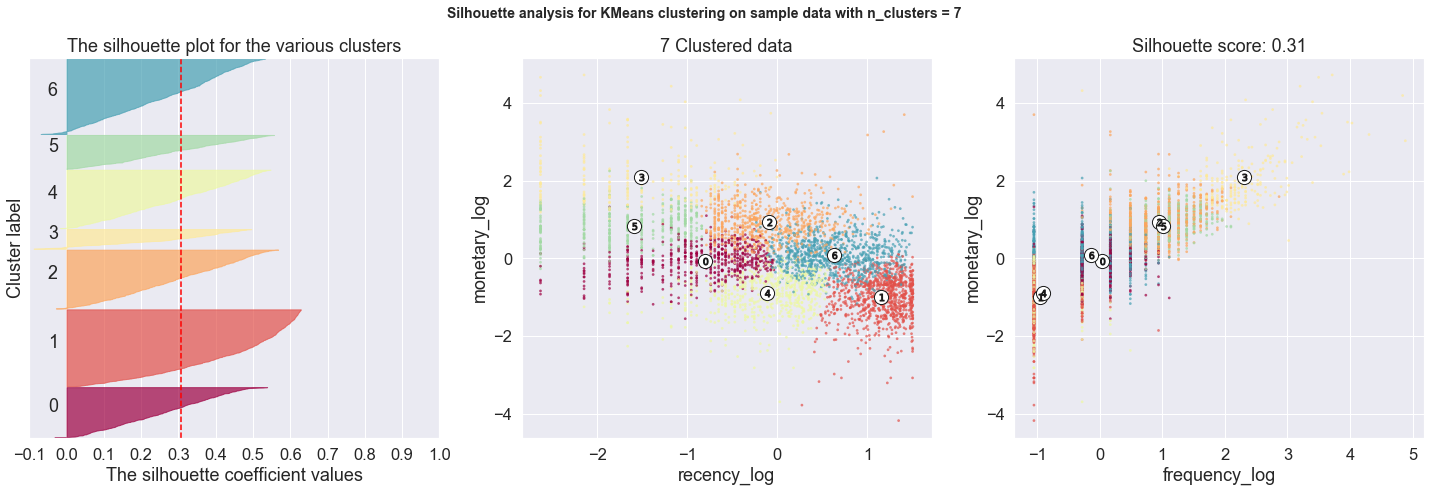

In [576]:
cluster_centers = dict()

for n_clusters in range(3,K_best+1):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(25, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)
    cluster_labels = clusterer.fit_predict(X_scaled)

    silhouette_avg = silhouette_score(X = X_scaled, labels = cluster_labels)
    cluster_centers.update({n_clusters :{'cluster_center':clusterer.cluster_centers_,
                                         'silhouette_score':silhouette_avg,
                                         'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X = X_scaled, labels = cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    
    centers = clusterer.cluster_centers_
    y = 0
    x = 1
    ax2.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax2.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax2.set_title("{} Clustered data".format(n_clusters))
    ax2.set_xlabel(feature_vector[x])
    ax2.set_ylabel(feature_vector[y])

    x = 2
    ax3.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax3.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax3.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax3.set_title("Silhouette score: {:1.2f}".format(cluster_centers[n_clusters]['silhouette_score']))
    ax3.set_xlabel(feature_vector[x])
    ax3.set_ylabel(feature_vector[y])
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()

**因为数据分布的原因导致区分度并不是特别好，因为根据销售数据进行用户区分，并不是总能发现比较明显的区分“界限”，也就是不同群体间的边界其实是非常模糊和混杂的**

In [577]:
features = ['monetary',  'recency',  'frequency']
for i in range(3,K_best+1):
    print("for {} clusters the silhouette score is {:1.2f}".format(i, cluster_centers[i]['silhouette_score']))
    print("Centers of each cluster:")
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=features))
    print('-'*50)

for 3 clusters the silhouette score is 0.34
Centers of each cluster:
      monetary     recency  frequency
0  1000.693460   34.035721   3.156270
1   260.526599  116.383828   1.189203
2  3940.487054    7.209425  10.008147
--------------------------------------------------
for 4 clusters the silhouette score is 0.33
Centers of each cluster:
      monetary     recency  frequency
0  4003.104515    6.555146  10.192850
1   264.013096  150.074965   1.190280
2   400.590967   13.897128   1.791716
3  1343.735445   54.151124   3.736927
--------------------------------------------------
for 5 clusters the silhouette score is 0.30
Centers of each cluster:
      monetary     recency  frequency
0   211.549673  153.935498   1.084346
1  5330.428536    4.287685  13.077065
2  1959.126040   24.531810   5.433186
3   841.506177  101.012447   2.356421
4   389.672044   13.720296   1.743406
--------------------------------------------------
for 6 clusters the silhouette score is 0.31
Centers of each cluster:
 

向下钻取聚类(Drill Down Cluster)：
为了进一步深入研究并找出这些数量上的差异，我们可以使用相应的聚类标签来标记我们的数据，然后将这些差异可视化。 

,CustomerID,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFMScore,RFMScore_level,recency_log,frequency_log,monetary_log,clusters_3,clusters_4,clusters_5,clusters_7
0,12346,326.0,1,77183.60,4,4,1,441,4,5.786897,0.000000,11.253942,0,3,3,2
1,12347,2.0,7,4310.00,1,1,1,111,1,0.693147,1.945910,8.368693,2,0,1,5
2,12348,75.0,4,1797.24,3,2,1,321,3,4.317488,1.386294,7.494007,0,3,2,2
3,12349,19.0,1,1757.55,2,4,1,241,3,2.944439,0.000000,7.471676,0,2,4,0
4,12350,310.0,1,334.40,4,4,3,443,4,5.736572,0.000000,5.812338,1,1,0,1


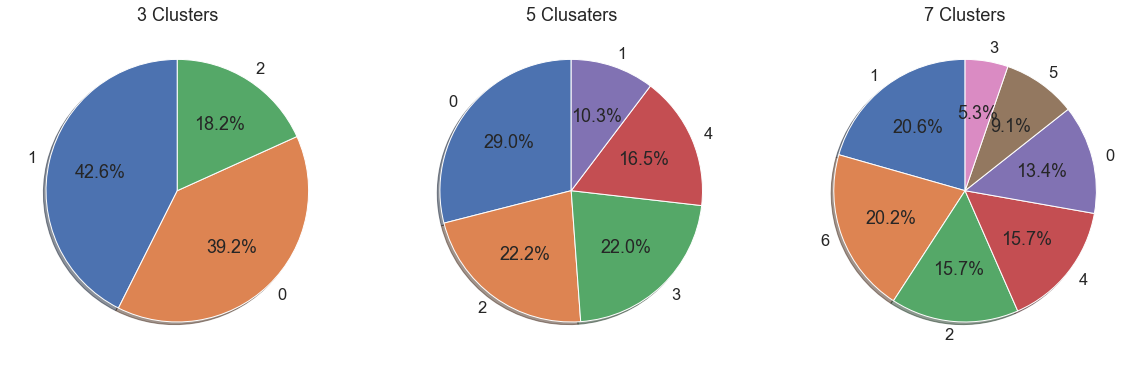

In [578]:

customer_history_df['clusters_3'] = cluster_centers[3]['labels']
customer_history_df['clusters_4'] = cluster_centers[4]['labels']
customer_history_df['clusters_5'] = cluster_centers[5]['labels']
customer_history_df['clusters_7'] = cluster_centers[7]['labels']
display(customer_history_df.head())

fig = plt.figure(figsize=(20,7))
f1 = fig.add_subplot(131)
market = customer_history_df.clusters_3.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('3 Clusters')
f1 = fig.add_subplot(132)
market = customer_history_df.clusters_5.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('5 Clusaters')
f1 = fig.add_subplot(133)
market = customer_history_df.clusters_7.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('7 Clusters')
plt.show()

In [579]:
customer_history_df.groupby(['RFMScore_level', 'clusters_4'])['CustomerID'].count()

RFMScore_level  clusters_4
1               0              572
                2                5
                3               41
2               0              165
                2              395
                3              457
3               0                5
                1              135
                2              350
                3              587
4               1             1448
                2                2
                3              176
Name: CustomerID, dtype: int64

In [580]:
customer_history_df.groupby(['RFMScore_level', 'clusters_7'])['CustomerID'].count()

RFMScore_level  clusters_7
1               0              10
                2              90
                3             204
                5             314
2               0             421
                2             376
                3              25
                4              95
                5              80
                6              20
3               0             151
                1               1
                2             197
                4             332
                6             396
4               1             892
                2              20
                4             252
                6             462
Name: CustomerID, dtype: int64

In [581]:
customer_history_df.groupby(['clusters_4','RFMScore_level'])['CustomerID'].count()

clusters_4  RFMScore_level
0           1                  572
            2                  165
            3                    5
1           3                  135
            4                 1448
2           1                    5
            2                  395
            3                  350
            4                    2
3           1                   41
            2                  457
            3                  587
            4                  176
Name: CustomerID, dtype: int64

In [582]:
customer_history_df.groupby(['clusters_7','RFMScore_level'])['CustomerID'].count()

clusters_7  RFMScore_level
0           1                  10
            2                 421
            3                 151
1           3                   1
            4                 892
2           1                  90
            2                 376
            3                 197
            4                  20
3           1                 204
            2                  25
4           2                  95
            3                 332
            4                 252
5           1                 314
            2                  80
6           2                  20
            3                 396
            4                 462
Name: CustomerID, dtype: int64

可以进一步优化，比如加入更多的features来做聚类：

例如:
- 用户第一次购买的时间
- 用户是不是从海外购买
- 用户购买的产品品类

也可以用更多的算法来实现，找到合适的分类，对于提高商业决策和优化客户转化提供了很大的价值。

### Decision Tree on RFM

In [583]:
segmented_rfm.head(1)

,CustomerID,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFMScore,RFMScore_level,recency_log,frequency_log,monetary_log,clusters_3,clusters_4,clusters_5,clusters_7
0,12346,326.0,1,77183.6,4,4,1,441,4,5.786897,0.0,11.253942,0,3,3,2


In [584]:
X = segmented_rfm.iloc[:,[1,2,3]].values
y = segmented_rfm.iloc[:,8].values

In [585]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [586]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [587]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = "entropy", random_state = 0)
clf_fit = classifier.fit(X_train,y_train)

In [588]:
y_pred = classifier.predict(X_test)

In [589]:
from sklearn.metrics import accuracy_score
print( "Accuarcy is of decision tree model is ", accuracy_score(y_pred, y_test)*100)

Accuarcy is of decision tree model is  99.90783410138249


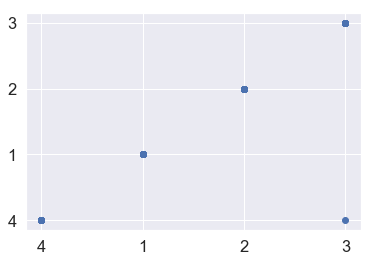

In [590]:
plt.scatter(y_test, y_pred)

In [591]:
segmented_rfm.shape

(4338, 16)

In [592]:
X = segmented_rfm.iloc[:,[1,2,3]].values
y = segmented_rfm.iloc[:,15].values

In [593]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [594]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [595]:
classifier = DecisionTreeClassifier(criterion = "entropy", random_state = 0)
clf_fit = classifier.fit(X_train,y_train)

In [596]:
y_pred = classifier.predict(X_test)

In [597]:
from sklearn.metrics import accuracy_score
print( "Accuarcy is of decision tree model is ", accuracy_score(y_pred, y_test)*100)

Accuarcy is of decision tree model is  96.036866359447


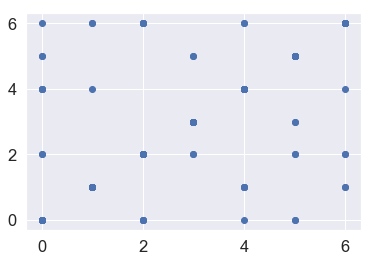

In [598]:
plt.scatter(y_test, y_pred)

In [ ]:
DecisionTreeClassifier?

In [599]:
for i in range(3,15,2):
    classifier = DecisionTreeClassifier(criterion = "entropy", max_depth = i, random_state = 0)
    clf_fit = classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    print( "Accuarcy of decision tree model with max_depth of ", i, "is", accuracy_score(y_pred, y_test)*100)

Accuarcy of decision tree model with max_depth of  3 is 79.26267281105991
Accuarcy of decision tree model with max_depth of  5 is 89.40092165898618
Accuarcy of decision tree model with max_depth of  7 is 93.82488479262673
Accuarcy of decision tree model with max_depth of  9 is 95.2995391705069
Accuarcy of decision tree model with max_depth of  11 is 96.036866359447
Accuarcy of decision tree model with max_depth of  13 is 96.036866359447


Logistic regression

In [ ]:
LogisticRegression?

In [600]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
clf_fit = classifier.fit(X_train,y_train)

In [601]:
y_pred = classifier.predict(X_test)

In [602]:
print( "Accuarcy is of logistic regression model is ", accuracy_score(y_pred, y_test)*100)

Accuarcy is of logistic regression model is  87.83410138248848


In [603]:
y_pred[:10]

array([6, 4, 5, 3, 0, 4, 0, 6, 2, 6])